In [137]:
#Libraries
import pandas as pd
import numpy as np
#import geopandas
import math
import datetime as dt
import os
import re
import scipy
import matplotlib.pyplot as plt
import seaborn as sea
%notebook matplotlib

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Correlation Beetween Income/Inequality and Homicides in Brazilian Cities

### Cleaning and filtering data of homicide deaths 

In [4]:
#Homicide deaths over the country
#source: Atlas da violencia - ipea.gov.br
#Firtly, I've to choose the year I'll look at to ensure all values I need is available in that year

df_h = pd.read_csv('homicidios.csv', sep = ';')
year = 2016
df_h = df_h[df_h.período == year].drop_duplicates(subset = 'cod', keep = 'first')
deaths = df_h['valor'].sum()
print('Number of homicides according to that database: {}'.format(deaths))

Number of homicides according to that database: 61531


In [5]:
#Homicids detahs in capitals
capitals = ['Manaus','Belém','Macapá','São Luís','Terezinha','Fortaleza','Natal','João Pessoa','Recife','Maceió',
'Aracaju','Salvador','Belo Horizonte','Vitória','Rio de Janeiro','São Paulo','Curitiba','Florianópolis','Porto Alegre',
'Cuiabá','Goiânia','Brasília','Campo Grande','Porto Velho','Boa Vista','Palmas','Rio Branco']

#Remove cities whose their name is the same of the capitals
df_cap_h = df_h[df_h['nome'].isin(capitals)].sort_values(by =['nome','valor']).drop_duplicates(subset = 'nome', keep = 'last')
print('number of capitals:',df_cap_h.shape[0])


deaths_cap = df_cap_h['valor'].sum()
codes_cap = df_cap_h['cod'].to_list()

percentage_cap = round((deaths_cap/deaths),4)
print('The capitals account for {}% of homicide deaths caused in Brazil ({})'.format(round(percentage_cap*100,2),year))
df_cap_h.head(10)

number of capitals: 27
The capitals account for 25.87% of homicide deaths caused in Brazil (2016)


,cod,nome,período,valor
210891,2800308,Aracaju,2016,468
210402,3106200,Belo Horizonte,2016,623
214674,1501402,Belém,2016,1101
214702,1400100,Boa Vista,2016,118
213174,5300108,Brasília,2016,760
213562,5002704,Campo Grande,2016,175
213471,5103403,Cuiabá,2016,217
212796,4106902,Curitiba,2016,557
213056,4205407,Florianópolis,2016,82
211222,2304400,Fortaleza,2016,1164


In [6]:
#Source: Base de Homicídios SIM
df_sim = pd.read_excel("1. SIM (Homicidios)//DadosHomicidios_2013-18_SIM.xlsx", sheet_name= 'Campos de interesse')

In [7]:
#Getting 15-29 years homicide deaths 
df_young = df_sim.copy()
df_young['DTOBITO'] = df_young['DTOBITO'].apply(lambda x: str(x)[-4:])
df_young = df_young[(df_young.CIRCOBITO == 3) & (df_young.IDADE >= 415) & (df_young.IDADE <= 429) & (df_young.DTOBITO == str(year)) ]
deaths = df_young.shape[0]
print('Number of homocides: {}'.format(deaths))

Number of homocides: 31101


**I'll try to get all cities that resulted in 80% of deaths (or something neart to that)**

In [8]:
target = round(0.8 *df_young.shape[0],2)
target

24880.8

In [9]:
#Grouping deaths by ciy
df_death = df_young.groupby(by = ['CODMUNOCOR']).agg({'CONTADOR': 'count'}).rename(columns = {df_young.columns[0]: "N_HOMICIDES"}).sort_values( by = 'N_HOMICIDES',ascending = False).reset_index()
all_cities = df_death.shape[0] # number f cities
df_death['Cumulative'] = df_death['N_HOMICIDES'].cumsum(axis = 0, skipna = True)
df_80 = df_death.iloc[:400,:]
df_80

,CODMUNOCOR,N_HOMICIDES,Cumulative
0,292740,931,931
1,330455,773,1704
2,230440,728,2432
3,261160,576,3008
4,130260,556,3564
...,...,...,...
395,310940,13,23799
396,521830,12,23811
397,315250,12,23823
398,351050,12,23835


In [10]:
#Checking duplicated city codes
duplicated = df_80.duplicated(subset ='CODMUNOCOR', keep = 'last' )
display(df_80[duplicated])
print('OK')

,CODMUNOCOR,N_HOMICIDES,Cumulative


OK


In [11]:
result = round(df_80.iloc[-1,-1]/deaths*100,2)
target_cities = round((df_80.shape[0]/all_cities)*100,2)
print("The 400 cities with the highest number of homocides({}% of cities provided by the SIM databse) account for {}% of deaths by homicide in {}".format(target_cities,result,year))

The 400 cities with the highest number of homocides(14.58% of cities provided by the SIM databse) account for 76.68% of deaths by homicide in 2016


### Loading data of develpment human informations and merging into the dataframe of deaths

In [12]:
df_atlas_hd = pd.read_excel('3. Atlas de Desenvolvimento Humano//Dados_registro_administrativo_total_2013_2017.xlsx', sheet_name= 'MUNICÍPIO')
df_atlas_hd

,ANO,DESAGREGACAO,IBGE7,NOME,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,PMATPRI_EM,DIST_EF_TOTAL,DIST_EM_TOTAL,...,SNIS_CDI,PFOCOS,PFLORA,PFEM_VEREADOR,PFEM_PREFEITO,PFEM_GOVERNADOR,PFEM_DEP_ESTADUAL,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT
0,2013,TOTAL,1100015,Alta Floresta D&apos;Oeste,99.26,100.00,0.74,NaN,25.8,29.6,...,100.0,0.51,66.02,20.00,0.0,NaN,NaN,NaN,NaN,25728
1,2013,TOTAL,1100023,Ariquemes,91.12,94.80,8.88,5.20,24.5,27.1,...,100.0,0.49,34.67,7.69,0.0,NaN,NaN,NaN,NaN,101269
2,2013,TOTAL,1100031,Cabixi,100.00,100.00,NaN,NaN,18.1,18.7,...,100.0,0.13,32.01,11.11,0.0,NaN,NaN,NaN,NaN,6495
3,2013,TOTAL,1100049,Cacoal,85.55,82.90,14.45,17.10,19.3,24.6,...,100.0,0.13,37.07,8.33,0.0,NaN,NaN,NaN,NaN,85863
4,2013,TOTAL,1100056,Cerejeiras,97.18,97.47,2.82,2.53,21.1,21.1,...,NaN,0.19,63.12,0.00,0.0,NaN,NaN,NaN,NaN,18041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27845,2017,TOTAL,5222005,Vianópolis,94.55,100.00,5.45,NaN,17.6,17.3,...,100.0,0.02,24.14,11.11,0.0,NaN,NaN,NaN,NaN,13675
27846,2017,TOTAL,5222054,Vicentinópolis,100.00,100.00,NaN,NaN,17.6,18.2,...,100.0,0.07,16.75,0.00,0.0,NaN,NaN,NaN,NaN,8397
27847,2017,TOTAL,5222203,Vila Boa,100.00,100.00,NaN,NaN,25.7,34.5,...,NaN,0.16,52.27,33.33,0.0,NaN,NaN,NaN,NaN,5731
27848,2017,TOTAL,5222302,Vila Propício,100.00,100.00,NaN,NaN,17.2,27.4,...,NaN,0.33,45.80,11.11,0.0,NaN,NaN,NaN,NaN,5690


In [13]:
#Merging dataframes
df_hd = df_atlas_hd.copy()
fields = ['ANO','IBGE7','NOME', 'REN_PIBPC_D', 'REN_VAPC_D', 'REN_PVAAGR', 'REN_PVAIND',
          'REN_PVAADM', 'REN_PVASERV', 'REN_RENSF_D', 'REN_TRPCBF_D', 'REN_TRPCBPC_D', 'PIND_POS',
          'PMPOB_POS','PPOB_POS','PBF',"POP_TOT", "TTREVA_EF_TOTAL","PDEFAGUA","PDEFESGOTO","PDEFLIXO","PDEFSAN"]

df_hd= df_hd[:][df_hd.ANO == year]
df_hd['CODMUN'] = df_hd['IBGE7'].map(lambda x: str(x)[:6])
df_hd

df_final = pd.merge(df_80.astype({'CODMUNOCOR':str}),df_hd, how = 'inner', right_on= 'CODMUN', left_on= 'CODMUNOCOR')
df_final

,CODMUNOCOR,N_HOMICIDES,Cumulative,ANO,DESAGREGACAO,IBGE7,NOME,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,...,PFOCOS,PFLORA,PFEM_VEREADOR,PFEM_PREFEITO,PFEM_GOVERNADOR,PFEM_DEP_ESTADUAL,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT,CODMUN
0,292740,931,931,2016,TOTAL,2927408,Salvador,65.23,79.68,34.77,...,0.00,10.72,11.63,0.0,NaN,NaN,NaN,NaN,2938092,292740
1,330455,773,1704,2016,TOTAL,3304557,Rio de Janeiro,66.82,72.37,33.18,...,0.25,26.01,15.69,0.0,NaN,NaN,NaN,NaN,6498837,330455
2,230440,728,2432,2016,TOTAL,2304400,Fortaleza,55.67,76.45,44.33,...,0.03,14.50,16.28,0.0,NaN,NaN,NaN,NaN,2609716,230440
3,261160,576,3008,2016,TOTAL,2611606,Recife,58.93,75.51,41.07,...,0.04,26.68,15.38,0.0,NaN,NaN,NaN,NaN,1625583,261160
4,130260,556,3564,2016,TOTAL,1302603,Manaus,84.71,91.72,15.29,...,0.18,82.89,12.20,0.0,NaN,NaN,NaN,NaN,2094391,130260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,310940,13,23799,2016,TOTAL,3109402,Buritizeiro,100.00,100.00,NaN,...,0.19,65.18,9.09,0.0,NaN,NaN,NaN,NaN,28251,310940
396,521830,12,23811,2016,TOTAL,5218300,Posse,89.49,96.40,10.51,...,0.26,53.51,15.38,0.0,NaN,NaN,NaN,NaN,35128,521830
397,315250,12,23823,2016,TOTAL,3152501,Pouso Alegre,82.96,80.74,17.04,...,0.04,9.07,13.33,0.0,NaN,NaN,NaN,NaN,145535,315250
398,351050,12,23835,2016,TOTAL,3510500,Caraguatatuba,87.59,90.98,12.41,...,0.01,77.14,6.67,0.0,NaN,NaN,NaN,NaN,115071,351050


In [14]:
#Computing the homicide rate for 15-29 years people
#Note: I could not find exactly the 15-29 years population of all cities in the databases provided by BCG GAMMA, then I used data from datasus.gov (homicides/100,000 pop)
df_pop = pd.read_excel('pop_15_29.xlsx', sheet_name= 'pop_15_29 tab')
df_pop = df_pop.drop(df_pop.index[-1], axis = 0)
df_pop['CODE'] = df_pop['Cidade'].apply(lambda string:re.compile(r'(^\d+)').search(string).group())
df_pop

,Cidade,População,CODE
0,110001 Alta Floresta D'Oeste,6169,110001
1,110037 Alto Alegre dos Parecis,3532,110037
2,110040 Alto Paraíso,5299,110040
3,110034 Alvorada D'Oeste,3876,110034
4,110002 Ariquemes,28981,110002
...,...,...,...
5565,522200 Vianópolis,3271,522200
5566,522205 Vicentinópolis,2089,522205
5567,522220 Vila Boa,1551,522220
5568,522230 Vila Propício,1289,522230


In [15]:
df_pop['População'].dtype

dtype('int64')

In [16]:
#Merging and computing the detah rate
df_check = pd.merge(df_final, df_pop, how = 'inner', left_on=  'CODMUN', right_on= 'CODE').rename(columns = {'População': '15_29_YEAR_POP'})

#Checking null values
null =df_check['CODE'].isnull()
display(df_check[null])

#Homicide rate-
df_check['HOMICIDE_RATE'] = (df_check['N_HOMICIDES']/df_check['15_29_YEAR_POP']) *100000
df_check.sort_values(by = 'HOMICIDE_RATE').head()

## Inserting 2015 education data
education = ["TTREVA_EF_TOTAL","TTREVA_EF_PUB"]
df_education = df_atlas_hd[df_atlas_hd.ANO == 2014][education + ["IBGE7"]]
df_check = pd.merge(df_check.drop(education, axis =1), df_education, how = 'inner', on ="IBGE7")

df_check

,CODMUNOCOR,N_HOMICIDES,Cumulative,ANO,DESAGREGACAO,IBGE7,NOME,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,...,PFEM_PREFEITO,PFEM_GOVERNADOR,PFEM_DEP_ESTADUAL,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT,CODMUN,Cidade,15_29_YEAR_POP,CODE


,CODMUNOCOR,N_HOMICIDES,Cumulative,ANO,DESAGREGACAO,IBGE7,NOME,PMATPUB_EF,PMATPUB_EM,PMATPRI_EF,...,PFEM_DEP_FEDERAL,PFEM_SENADOR,POP_TOT,CODMUN,Cidade,15_29_YEAR_POP,CODE,HOMICIDE_RATE,TTREVA_EF_TOTAL,TTREVA_EF_PUB
0,292740,931,931,2016,TOTAL,2927408,Salvador,65.23,79.68,34.77,...,NaN,NaN,2938092,292740,292740 Salvador,697530,292740,133.470962,7.1,5.7
1,330455,773,1704,2016,TOTAL,3304557,Rio de Janeiro,66.82,72.37,33.18,...,NaN,NaN,6498837,330455,330455 Rio de Janeiro,1481354,330455,52.181990,4.3,4.3
2,230440,728,2432,2016,TOTAL,2304400,Fortaleza,55.67,76.45,44.33,...,NaN,NaN,2609716,230440,230440 Fortaleza,700132,230440,103.980392,4.6,6.1
3,261160,576,3008,2016,TOTAL,2611606,Recife,58.93,75.51,41.07,...,NaN,NaN,1625583,261160,261160 Recife,390248,261160,147.598450,6.1,6.3
4,130260,556,3564,2016,TOTAL,1302603,Manaus,84.71,91.72,15.29,...,NaN,NaN,2094391,130260,130260 Manaus,585436,130260,94.971953,3.2,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,310940,13,23799,2016,TOTAL,3109402,Buritizeiro,100.00,100.00,NaN,...,NaN,NaN,28251,310940,310940 Buritizeiro,7491,310940,173.541583,2.5,2.5
396,521830,12,23811,2016,TOTAL,5218300,Posse,89.49,96.40,10.51,...,NaN,NaN,35128,521830,521830 Posse,9382,521830,127.904498,2.4,2.7
397,315250,12,23823,2016,TOTAL,3152501,Pouso Alegre,82.96,80.74,17.04,...,NaN,NaN,145535,315250,315250 Pouso Alegre,36566,315250,32.817371,1.6,1.7
398,351050,12,23835,2016,TOTAL,3510500,Caraguatatuba,87.59,90.98,12.41,...,NaN,NaN,115071,351050,351050 Caraguatatuba,26905,351050,44.601375,1.9,2.0


### Statistical Analysis

In [17]:
df_check.to_excel('14-29 year homicide rate x socieconomic data 2016.xlsx', index = False)

In [18]:
#Sort values
df_check =  df_check.sort_values(by = 'REN_PIBPC_D', ascending = True)
df_check["TTREVA_EF_TOTAL"]

316    8.2
179    5.7
303    8.2
191    4.3
183    5.9
      ... 
269    2.1
112    1.9
119    4.0
115    2.7
393    1.8
Name: TTREVA_EF_TOTAL, Length: 400, dtype: float64

In [19]:
#Input variable
variable = 'REN_PIBPC_D'


#Computing the correlation between GDP per capita and homicide rate
corr_gdp = df_check['HOMICIDE_RATE'].corr(df_check[variable], method = "pearson")
print('Corr: ', corr_gdp )

Corr:  -0.2581578109527439


In [20]:
# Linear regression (Ordinary least squares)
#Using a first degree equation (f(x) = a + bx) to approximate

X = df_check[variable].to_numpy()
Y = df_check['HOMICIDE_RATE'].to_numpy()

# Getting rid of outliers:
#X = X[:-5]
#Y = Y[:-5]

linear_coef = np.polyfit(y = Y, x = X ,deg = 1)
a1,a0 = linear_coef
F = a0 + a1 *X
print('f(x) = {} + {}x'.format(a0,a1))

f(x) = 134.2648133286579 + -1.3211922766369064x


#### Least Squares Error (Sum os Squared Errors - SSE)
$SSE = \sum_{i=1}^n (y_i - f_{i})^2$
- Where $y_i$ is the actual value for data point i
- $f_i = f(x_i)$ is the value resulted by the model I choosed

In [21]:
print('SSE: ', np.sum((Y-F)**2))

SSE:  1497354.6256848415


Let's try another function to fit the data: a polyomial of n degree
- $G(x) = a_0 + a_1 x + a_2 x^2 +.. + a_n x^n$
- $i = 0,1,2,..,n$
- $G(x) \in  [1,x,x^2,...,x^n]$
$$[ <G_{i},G_{j}>] \dot [a_0,a_1,...,a_n]^{T} = [<G_{i}Y>] \Rightarrow Aa = B \rightarrow a = A^{-1}B $$

In [22]:
#Applying  least squares algorithm

m = 3 # number of matrix colum/row (mXm) - n+1 equations
A = np.zeros([m,m]) # Produt scalar matrix [<Gi,Gj>] mXm
B = np.zeros([m,1]) # Independent matrix [<Gj,Yi]> mx1

for i in range(m): # n + 1 degree equation
    for j in range(m):
        A[i][j] = np.sum((X**i)*(X**j))     
        
for i in range(m):
    B[i][0] = np.sum(Y*X**i)

#Linear System solution AX = B --> X = BA^-1
matrix_solution = np.linalg.inv(A).dot(B)
a,b,c = matrix_solution

G = 0
for i in range(len(matrix_solution)):
    G += matrix_solution[i]*X**i    

In [23]:
from numpy.polynomial.polynomial import Polynomial

#Sum of squared error
print('SSE: ', np.sum((Y-G)**2))

#showing coeficients
y = np.polyfit(X,Y,2)
p = np.poly1d(y)
Polynomial(p)

SSE:  1467553.3895980553


Polynomial([ 1.94321236e-02, -2.65121683e+00,  1.48257783e+02], domain=[-1,  1], window=[-1,  1])

I Want to model my data by a negative  negative exponential function becasuse I believe it's the most suitable equation. So I should apply non-linear regression
- Function I will approximate: $ \Large H(x) = \frac{s}{x^t}$
- Linearization: $z(x) = ln(H(x)) = ln(s) - ln(x)t \Rightarrow \alpha = ln(s) \space,\space \beta = -b \space,\space t(x) = ln(x) $
- Linearized function: $z(x) = \alpha + \beta x$

In [24]:
#Non linear regression

#log of function G(x)
#T = np.log(X)
Z =np.log(Y)
T = np.log(X)

H = {0: np.array([1]*len(T)), 1:T} #My approximation function h(X)= alpha + beta X
m = len(H) # number of matrix colum/row (mXm) - n+1 equations
A = np.zeros([m,m]) # Produt scalar matrix [<Gi,Gj>] mXm
B = np.zeros([m,1]) # Independent matrix [<Gj,Yi]> mx1


for i in range(m): # n + 1 degree equation
    for j in range(m):
        A[i][j] = np.sum(H[i]*H[j])     
        
for i in range(m):
    B[i][0] = np.sum(Z*H[i])

#Linear System solution AX = B --> X = BA^-1
matrix_solution = np.linalg.inv(A).dot(B)
alpha,beta = matrix_solution

#Figure out the constants of the exponential function
s = np.exp(alpha)
t= - beta

#G(X)
#G_non_linear =s * np.exp(-t*X)
G_non_linear = s/((X-5)**t)- 50
G_non_linear = np.nan_to_num(G_non_linear)

C:\Users\Rodolfo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


In [25]:
G_non_linear = np.nan_to_num(G_non_linear)

#Sum of squared error
print('SSE: ', np.sum((Y[12:]-G_non_linear[12:])**2))


SSE:  2460527.3875199305


C:\Users\Rodolfo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


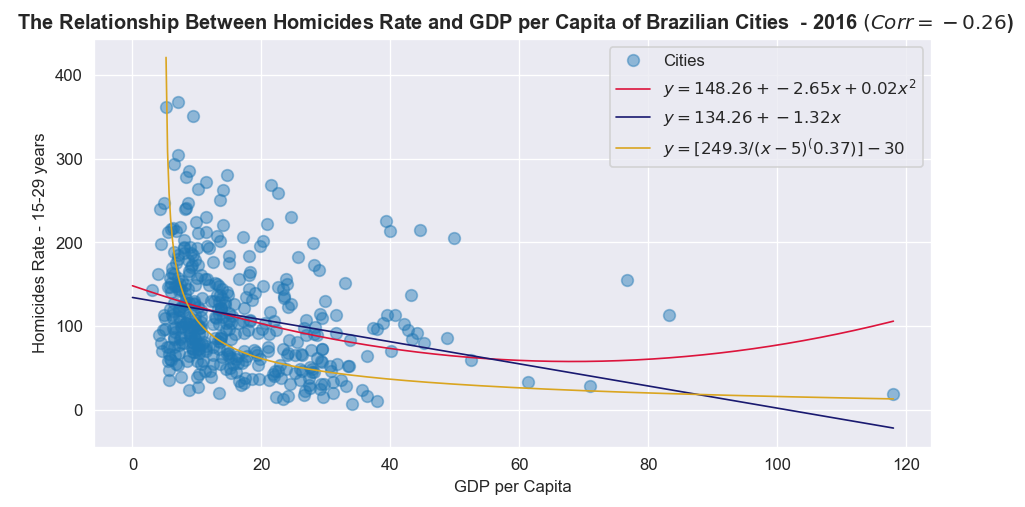

In [26]:
#Plotting---------------------------------------

plt.figure()
sea.set_style('darkgrid', {'axis.grid': True})

#Scatter
plt.plot(X,Y,'o',linewidth = 2.4, markersize = 7, alpha = 0.45, label = 'Cities')
    
#Labels
plt.xlabel('GDP per Capita')
plt.ylabel('Homicides Rate - 15-29 years')
plt.title(' The Relationship Between Homicides Rate and GDP per Capita of Brazilian Cities  - {} $(Corr = {}$)'.format(year,round(corr_gdp,2)), fontweight = 'bold')

#Fitting data
xplot = np.linspace(0,X[-1],500)
fplot =np.array([],float) # f(x) = a0 + a1x
gplot =np.array([],float) # g(x) = a + bx + cx^2
hplot =np.array([],float) # h(x) = d/x^e
for xi in xplot:
    fi = a0 + a1*xi
    fplot = np.append(fplot,fi)
    gi = a + b*xi + c*xi**2
    gplot = np.append(gplot,gi)
    hi = (s/((xi-5)**t))- 30
    hplot = np.append(hplot,hi)


plt.plot(xplot,gplot,'-', linewidth = 1, c= 'crimson', label = '$y = {} + {}x + {}x^2$'.format(round(a[0],2),round(b[0],2),round(c[0],2)))
plt.plot(xplot, fplot,'-', linewidth = 1, c= 'midnightblue', label = '$y = {} + {}x$'.format(round(a0,2),round(a1,2)))
plt.plot(xplot, hplot,'-', linewidth = 1, c= 'goldenrod', label = '$y = [{}/(x-5)^ ({})]-30$'.format(round(s[0],2),round(t[0],2)))

#Legend
plt.legend(loc = 'best', shadow = False, frameon = True, framealpha = 0.8)
#Settings
plt.gcf().set_dpi(120)
plt.gcf().set_size_inches(9,4.5)

**Note: Even though the squared error of the secound degree equation is the lowest, the non-linear function of type a/(x-5)^b seems to fit the data better**

### Let's talke a fast look at some correlations between socioeconomic vairables

In [134]:
#Getting the metrics names of alls fields
#Source: Atlas de Desenvolvimento Humano 2013-2017
df_metric = pd.read_excel("3. Atlas de Desenvolvimento Humano\\Dados_registro_administrativo_total_2013_2017.xlsx", sheet_name= "LEGENDA")
df_metric = df_metric[df_metric.columns].set_index('SIGLA', drop = True)
dict_metric = dict(df_metric[df_metric.columns[0]])

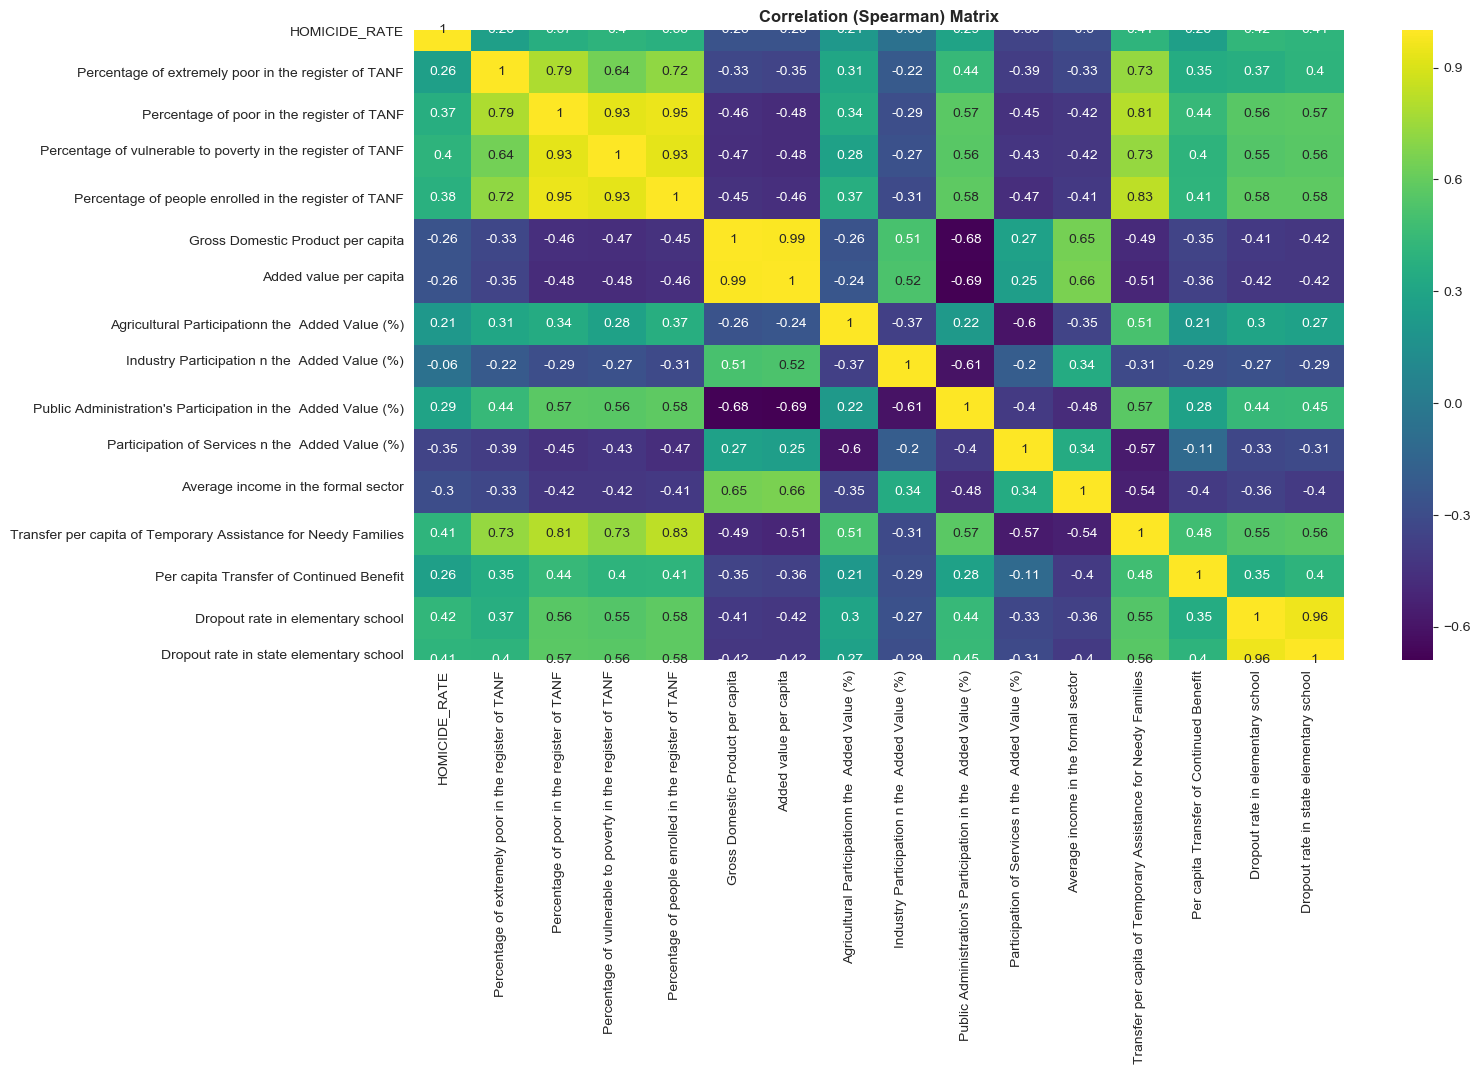

In [136]:
fields =[
"CODE",
"HOMICIDE_RATE",
"PIND_POS",
"PMPOB_POS",
"PPOB_POS",
"PBF",
"REN_PIBPC_D",
"REN_VAPC_D",
"REN_PVAAGR",
"REN_PVAIND",
"REN_PVAADM",
"REN_PVASERV",
"REN_RENSF_D",
"REN_TRPCBF_D",
"REN_TRPCBPC_D",
"TTREVA_EF_TOTAL",
"TTREVA_EF_PUB"]
df_income = df_check[fields].set_index('CODE', drop = True)

#Rename columns
#All correlation
corr_inc =  df_income.rename(columns = dict_metric).corr()
sea.heatmap(round(corr_inc,2), annot = True,cmap = 'viridis')
plt.title("Correlation (Spearman) Matrix", fontweight = 'bold', fontsize = 12)

#Setting
plt.gcf().set_size_inches(15,10)
plt.gcf().set_dpi(100)
plt.subplots_adjust(bottom = .25)

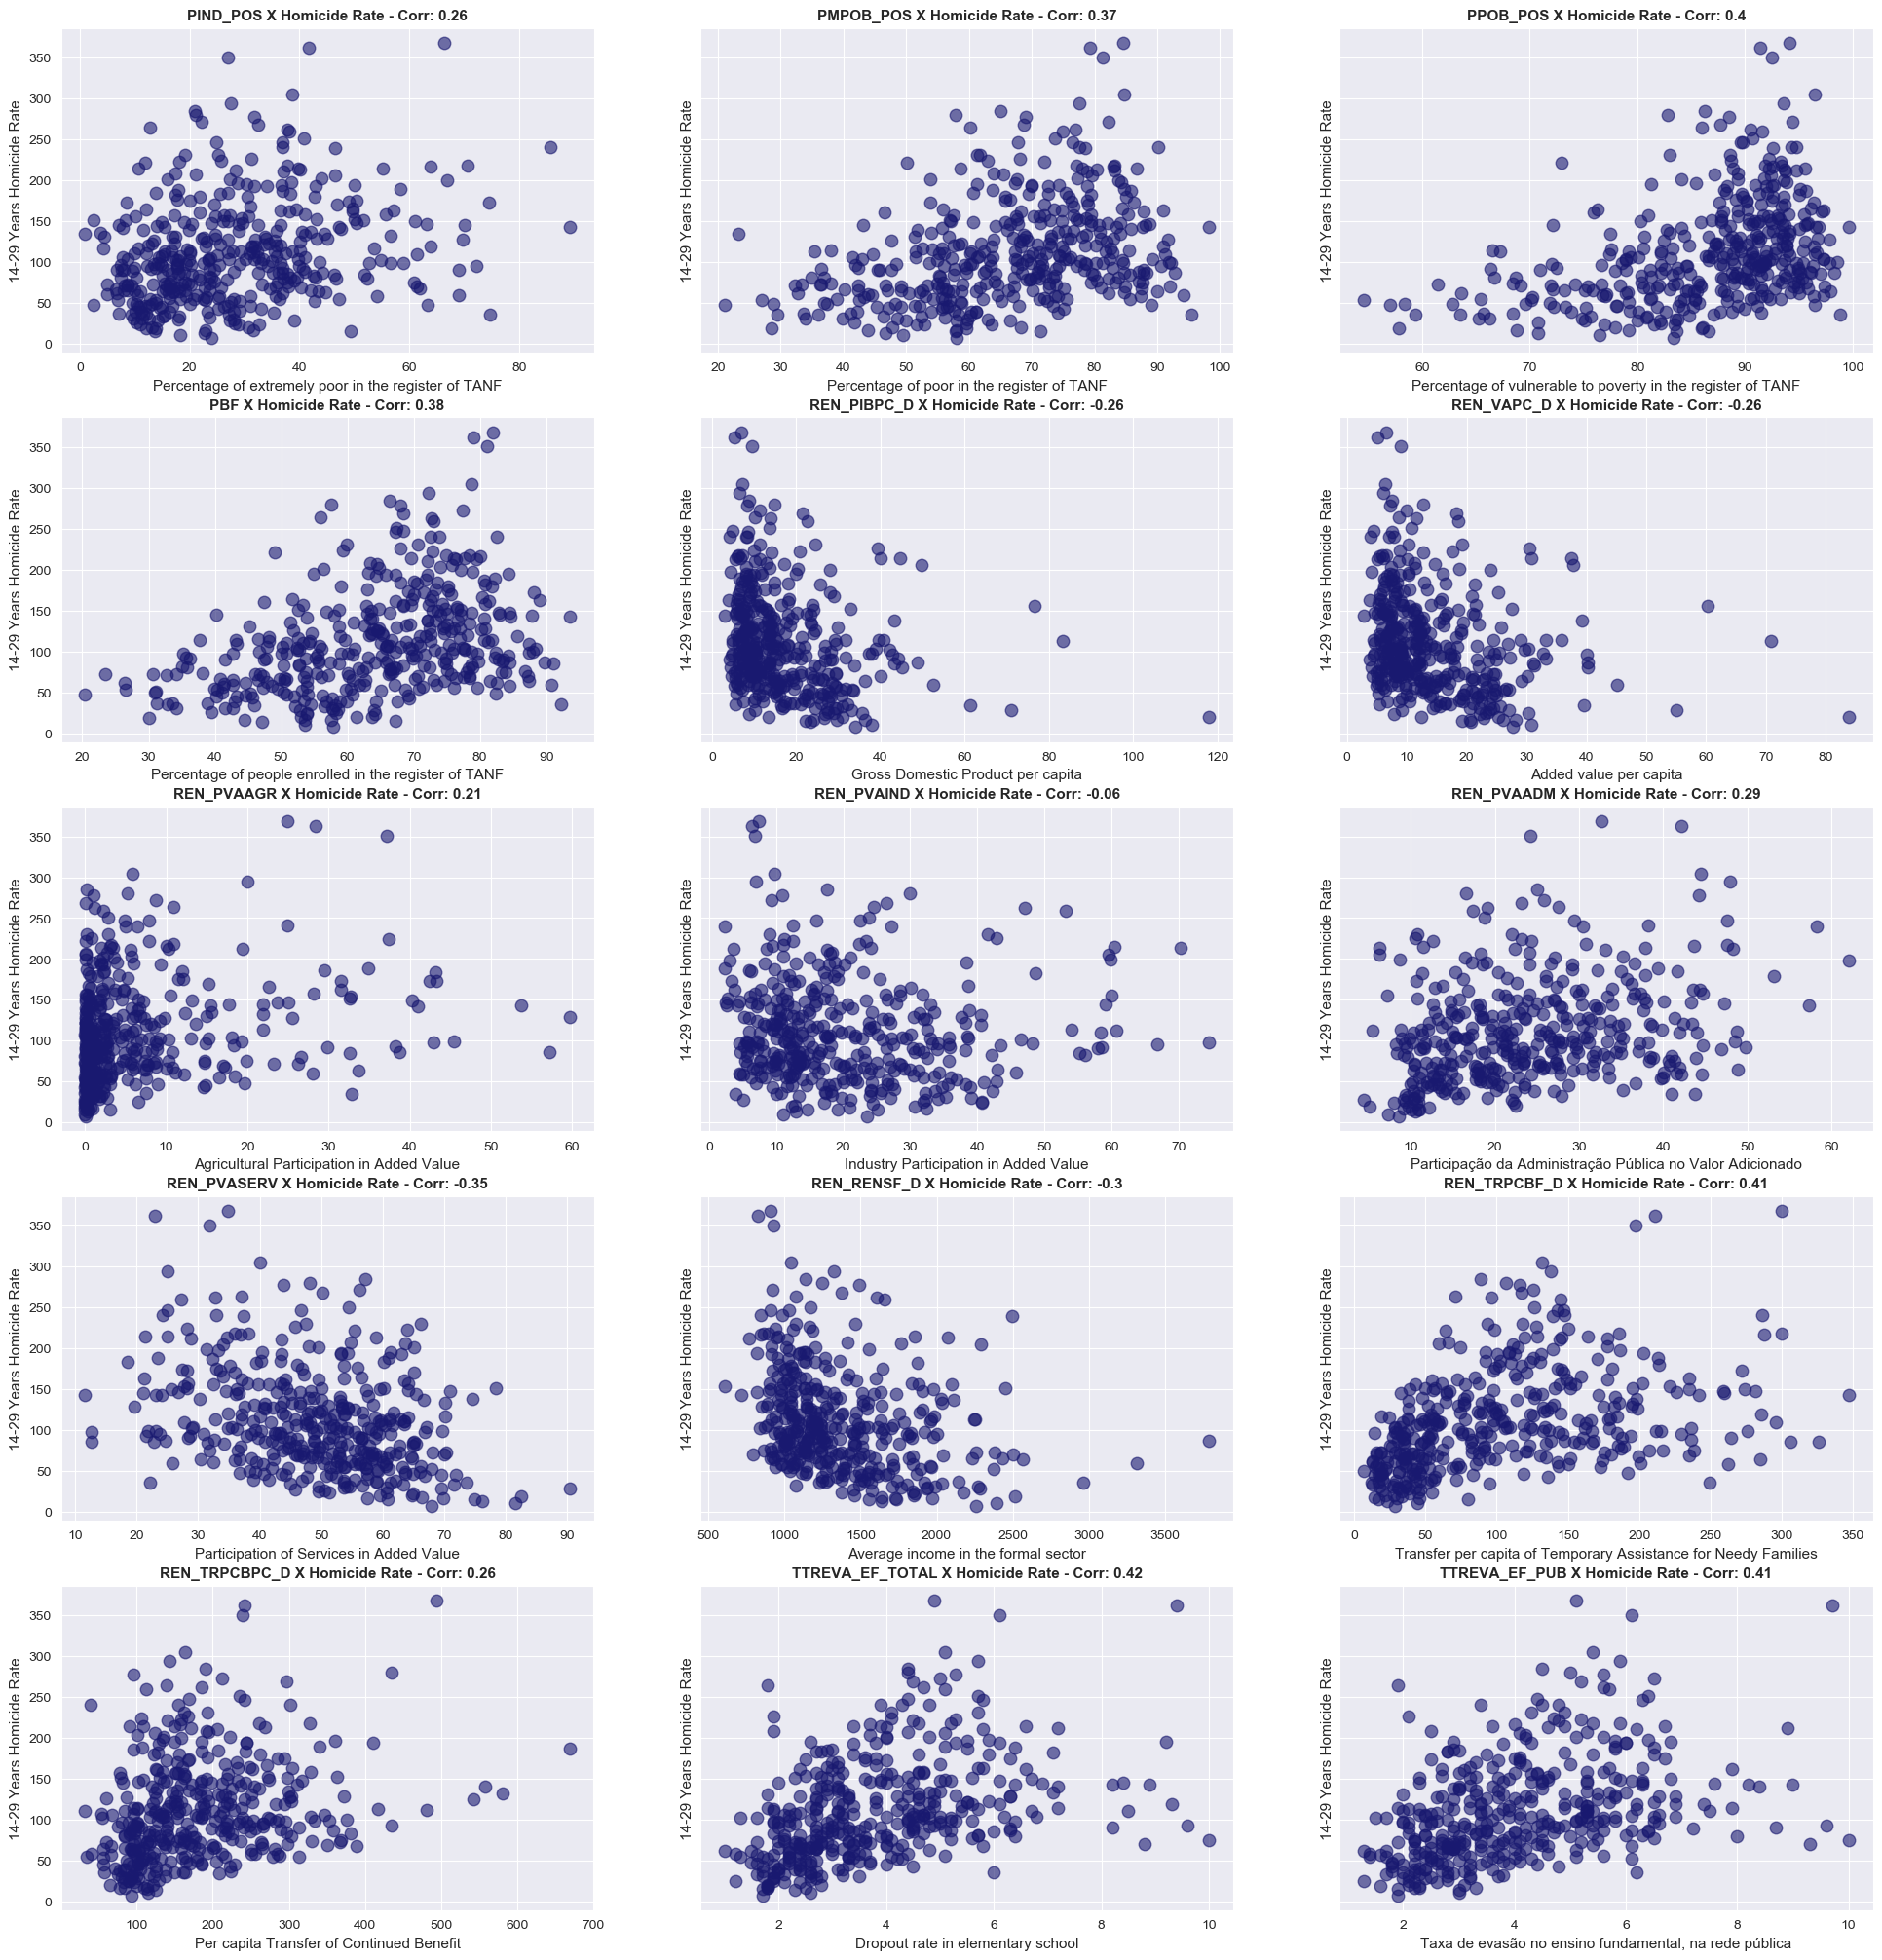

In [69]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(5,3, sharey = True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13, ax14, ax15]
columns = list(df_income.columns)
columns.remove("HOMICIDE_RATE")

for col,ax in zip(columns,axes):
    
    #pearson correlation
    corr = df_income["HOMICIDE_RATE"].corr(df_income[col], method = 'pearson')
    #Plotting
    ax.plot(df_income[col], df_income['HOMICIDE_RATE'],'o',color =  'midnightblue', markersize = 9, alpha = 0.6)
    ax.set_xlabel(dict_metric[col], fontsize = 11)
    ax.set_ylabel('14-29 Years Homicide Rate', fontsize = 11)
    ax.set_title("{} X Homicide Rate - Corr: {}".format(col,round(corr,2)) ,size = 11, fontweight = 'bold')
       
    
#Setting
plt.gcf().set_size_inches(24,14)
plt.gcf().set_dpi(100)
plt.subplots_adjust(bottom = -0.5)
plt.savefig('Correlations_Income.pdf', quality = 97, optimize = True)

**Comparing more than two variable at once**

<Figure size 432x288 with 0 Axes>

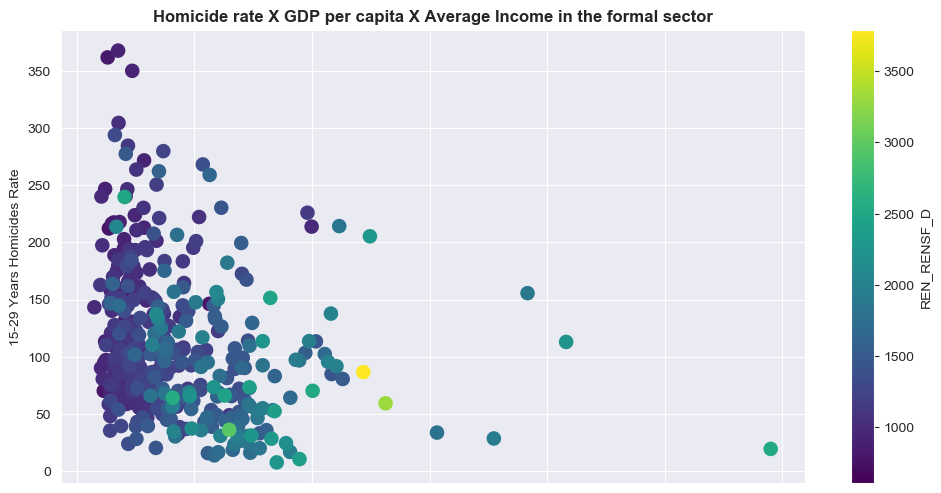

In [70]:

plt.figure()
df_income.plot(kind ="scatter", x= "REN_PIBPC_D", y = 'HOMICIDE_RATE' , c='REN_RENSF_D', colormap='viridis',figsize = (12,6), linewidth = 6)

plt.xlabel('GDP per Capita')
plt.ylabel('15-29 Years Homicides Rate')
plt.title('Homicide rate X GDP per capita X Average Income in the formal sector', fontweight = 'bold')
plt.gcf().set_size_inches(12,6)
plt.gcf().set_dpi(100)
#plt.subplots_adjust(bottom = -.1)

**Comparing GDP per capita X Homicide Rate with a third variable in the same graphic**

Note: The color scale shows the variable written in the title of each scatter plot

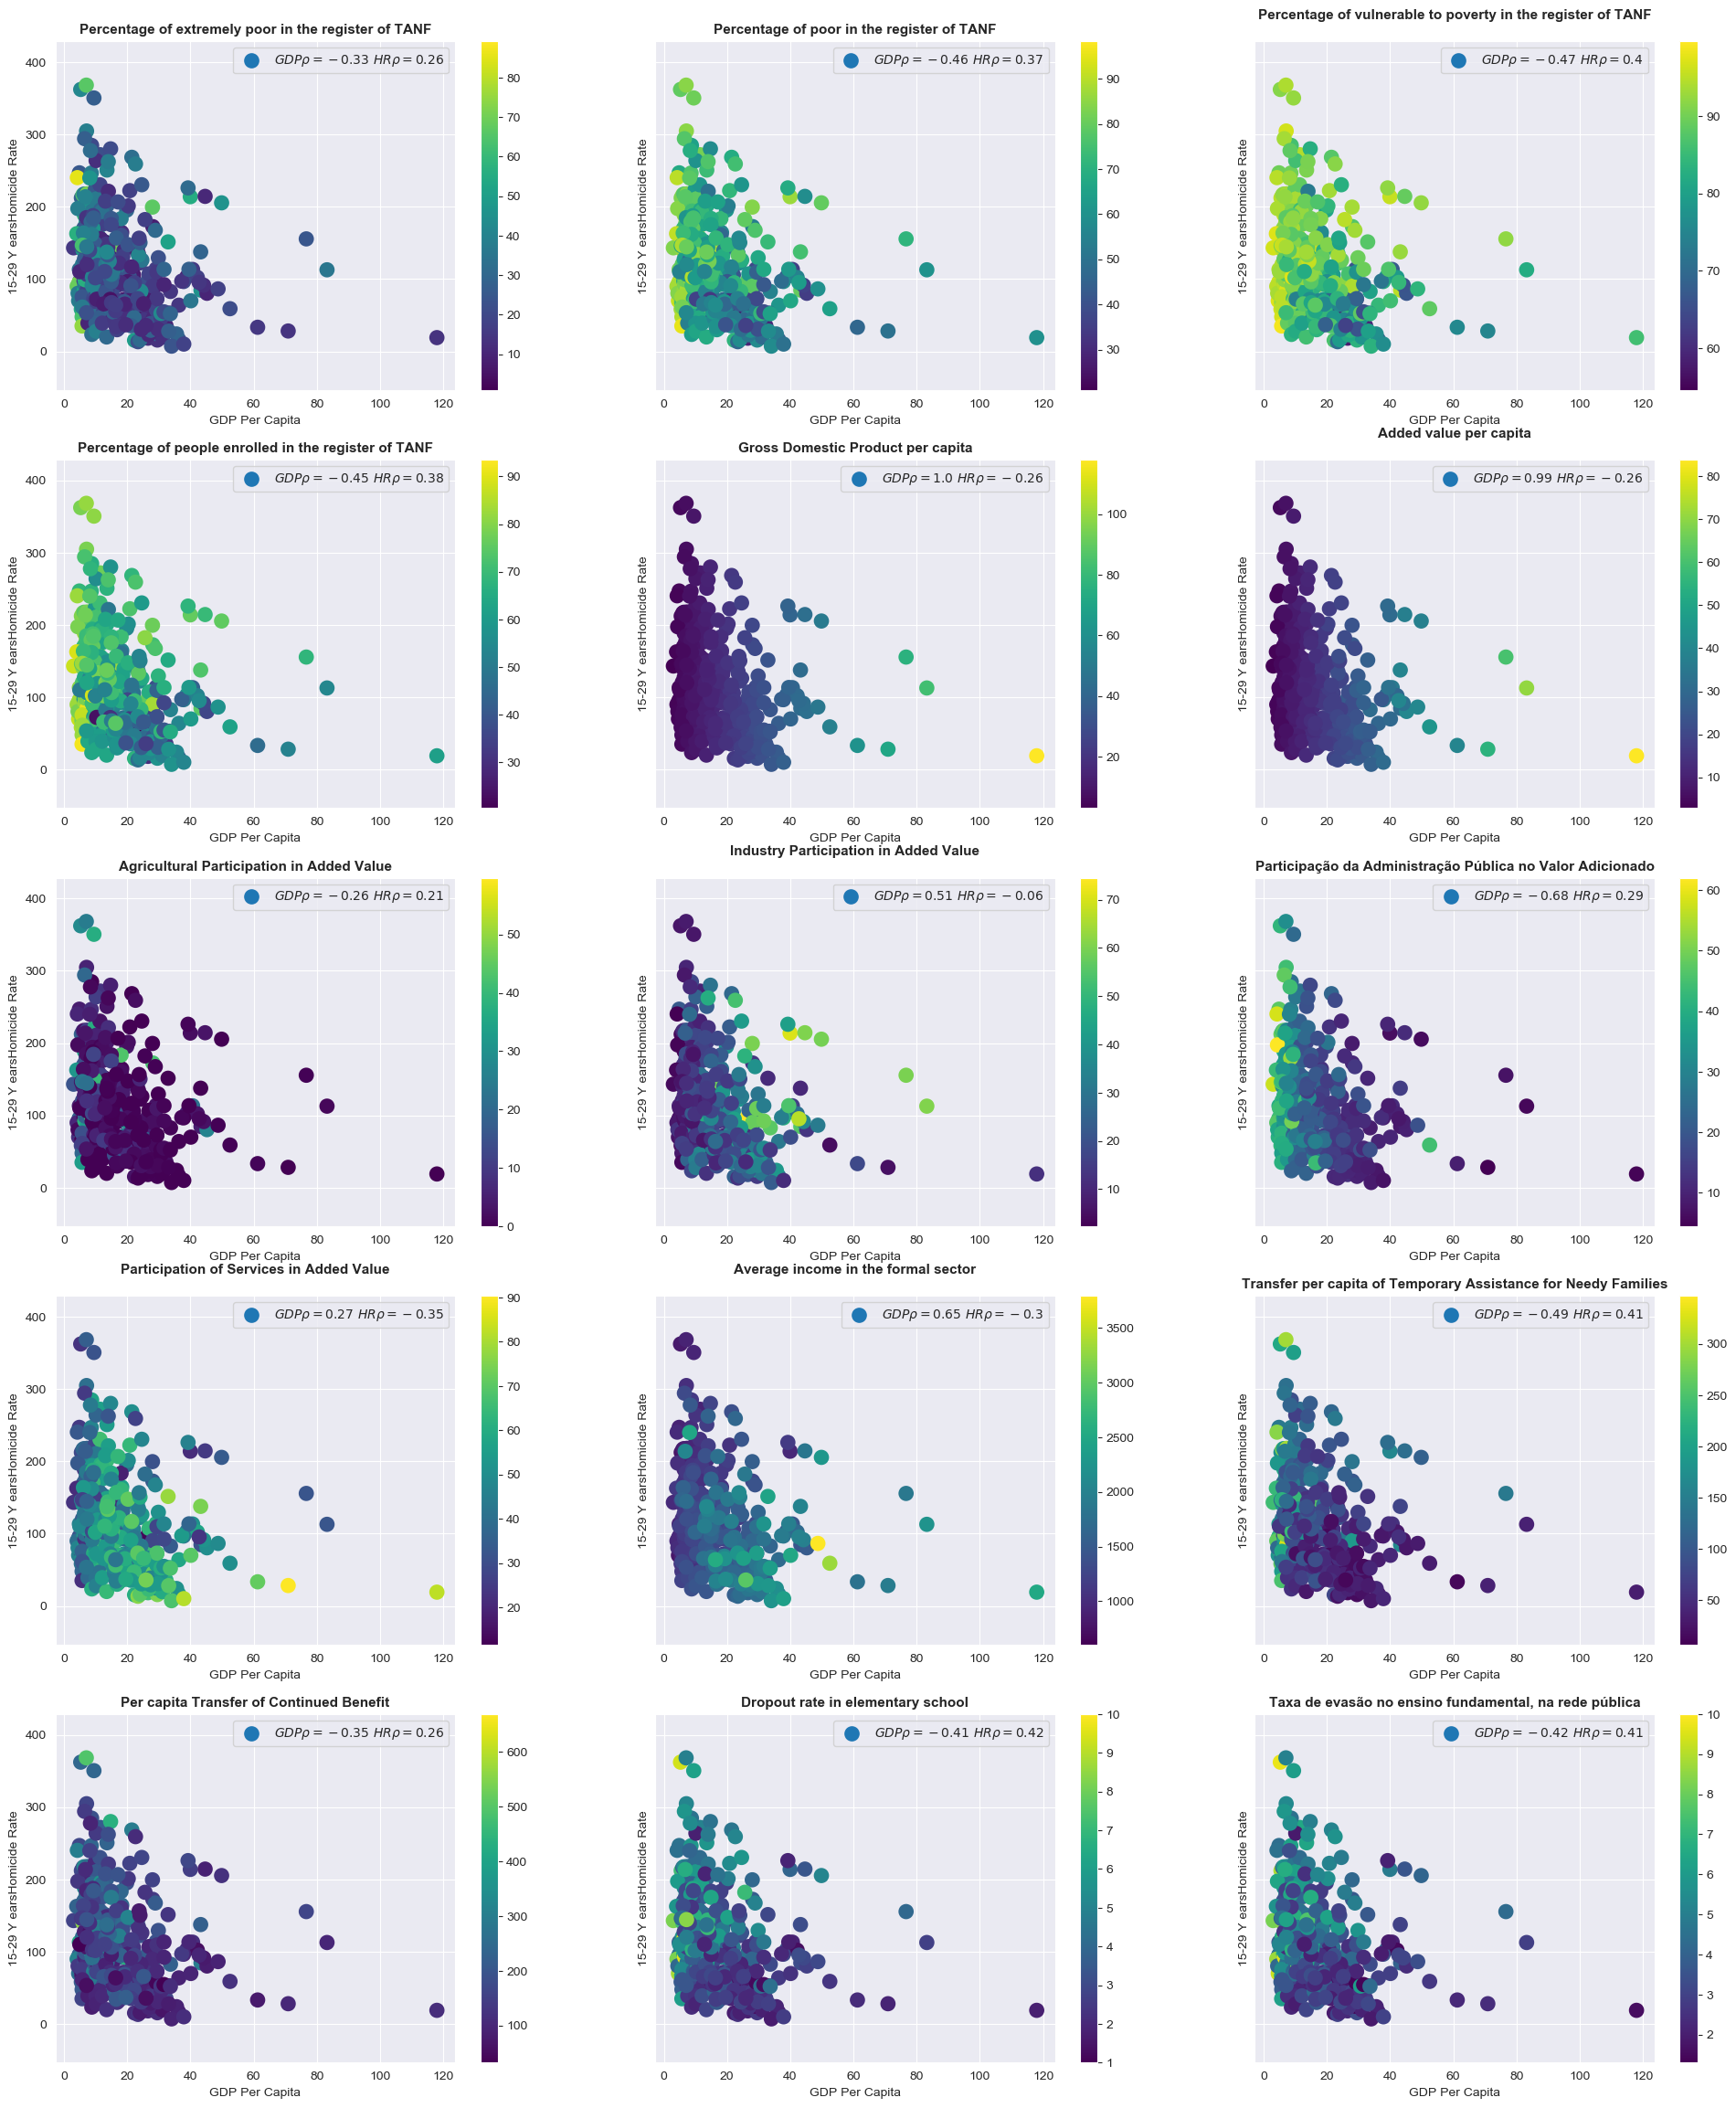

In [71]:

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(5,3, sharey = True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15]
columns = list(df_income.columns)
columns.remove("HOMICIDE_RATE")
#columns.remove("HOMICIDE_RATE")


for col,ax in zip(columns,axes):
    
    #Pearson correlation
    corr_gdp = round(df_income["REN_PIBPC_D"].corr(df_income[col]),2)
    corr_hr = round(df_income["HOMICIDE_RATE"].corr(df_income[col]),2)
    
    #Plotting
    scatter = ax.scatter(x= df_income["REN_PIBPC_D"], y = df_income['HOMICIDE_RATE'] , c = df_income[col], linewidth = 6, cmap = 'viridis', label = "$GDP \\rho ={}   \\ HR \\rho = {}$".format(corr_gdp,corr_hr))
    fig.colorbar(mappable = scatter,ax =ax)

    #labels
    ax.set_xlabel("GDP Per Capita", fontsize = 10)
    ax.set_ylabel('15-29 Y earsHomicide Rate', fontsize = 10)
    ax.set_title("{}".format(dict_metric[col]) ,size = 11, fontweight = 'bold')
    ax.legend(loc = 'best')
      
#Setting
plt.gcf().set_size_inches(24,14)
plt.gcf().set_dpi(100)
plt.subplots_adjust(bottom = -0.7)
plt.savefig('Correlations_Income.pdf', quality = 97, optimize = True)

### Notes

**Some remarks about the scatterplot between homicide rate X GDP per capita X public administration participation in the added value**
- There's a horizontal gradient, showing that GDP declines since the cities depend more on economic activities arise out of the public administration.
- The correlation between GDP per capita and value-added of public administration is strongly negative: $\rho$ =  -0.68
- We can note a lower contrast in the vertical gradient, which indicates that the value-added doesn't much vary for an interval of GDP per capita. The more dependence on public administration for wealth generation,  $\rho$ = 0.29
- Those considerations find evidence in the CNM survey, showing that a significant part of the cities depend on the GDP coming from the public administration activities and, these cities are more localized in the Northeast, the poorest region in Brazil: https://www.cnm.org.br/comunicacao/noticias/pib-municipal-economia-de-2-7-mil-municipios-depende-da-administracao-publica

**Some remarks about  the scatterplot between homicide rate X GDP per capita X  transfer per capita of Temporary Assistance For Needy Families (TANF - It's called Bolsa Família in Brazil)**
- At the vertical gradient, we can see the per capita transference of TANF increases as the homicide rate rises, $\rho$ = 0.41
- There's a notorious horizontal gradient  where we can look at the transfer of Bolsa Família decreasing  while GDP per capita are increasing,  $\rho$ = -0.49
- It shows us there is no evidence that the welfare benefits distributed by the government can mitigate the number of murders.

**Some remarks about the scatterplot between homicide rate X GDP per capita X Average income in the formal sector**
- At the gradient vertical, we can notice the average income diminishes while the homicide rate goes up. A significant Spearman correlation is noticeable:  $\rho$ = -0.3.
- Among all variables, the highest positive correlation between the GDP per capita is the average in the formal sector, pointing out a 65% correlation.

**Some remarks about the scatterplot between homicide rate X GDP per capita X Dropout rate in elementary school**

- The fact of cities with high school dropouts indicating a low GDP per capita and a high homicide rate gets the attention. That converges to two researchers: the classic correlation  between mean years of schooling and GDP per capita (https://ourworldindata.org/grapher/correlation-between-mean-years-of-schooling-and-gdp-per-capita)
- For school dropout rate, the correlation between  GDP/person  and homicide rate is $\rho$  = -.041 and $\rho$  = 0.42 respectively.

### Variance Analysis

In [32]:
df_income

,HOMICIDE_RATE,PIND_POS,PMPOB_POS,PPOB_POS,PBF,REN_PIBPC_D,REN_VAPC_D,REN_PVAAGR,REN_PVAIND,REN_PVAADM,REN_PVASERV,REN_RENSF_D,REN_TRPCBF_D,REN_TRPCBPC_D,TTREVA_EF_TOTAL,TTREVA_EF_PUB
CODE,,,,,,,,,,,,,,,,
210830,143.228001,15.40,83.56,96.58,87.77,3.01,2.87,15.46,4.17,57.31,23.07,980.25,241.89,158.54,8.2,8.2
150330,162.793309,57.04,90.97,97.28,89.01,4.02,3.78,31.55,3.74,43.55,21.16,1135.39,235.17,232.97,5.7,5.7
210360,89.988751,68.95,87.89,94.99,82.90,4.14,3.84,6.30,7.10,46.87,39.73,975.93,264.18,313.53,8.2,8.7
260420,240.299039,85.68,90.15,94.73,82.59,4.21,3.96,6.40,2.35,58.27,32.98,985.61,286.16,301.66,4.3,4.5
260260,197.572679,38.50,84.28,93.82,78.86,4.36,4.07,1.74,3.06,62.01,33.19,1031.37,186.23,133.84,5.9,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420820,33.415635,15.13,46.43,75.69,46.02,61.26,39.60,0.83,18.29,9.39,71.49,1804.26,13.00,75.00,2.1,2.3
353440,28.258948,14.13,49.98,75.14,52.80,70.93,54.99,0.00,5.17,4.47,90.36,1930.19,37.85,102.48,1.9,2.4
260720,155.615440,24.72,71.29,92.12,68.39,76.66,60.32,0.42,59.97,7.17,32.44,1883.32,144.12,162.11,4.0,4.3


In [113]:
variable = "REN_PIBPC_D"
#GDP per  capita
df_income['GDP_QUANTILE'] = df_income[variable].apply(lambda x: "0-10" if x <= 10 else 
                                                                ("10-20" if x > 10 and x <=20 else
                                                                ("20-30" if x > 20 and x <=30 else
                                                                ("30-40" if x > 30 and x <=40 else
                                                                ("40-50" if x > 40 and x <=50 else
                                                                ("> 50" if x > 50 else x))))))

#Average income in the formal sector
df_income['FORM_SEC_QUANTILE'] = df_income["REN_RENSF_D"].apply(lambda x: "0-500" if x <= 500 else 
                                                                ("500-1000" if x > 500 and x <= 1000 else
                                                                ("1000-1500" if x > 1000 and x <=1500 else
                                                                ("1500-2000" if x > 1500 and x <=2000 else
                                                                ("2000-2500" if x > 2000 and x <=2500 else
                                                                ("2500-300" if x > 2000 and x <=3000 else
                                                                ("> 3000" if x > 3000 else x)))))))
df_income.head()

,HOMICIDE_RATE,PIND_POS,PMPOB_POS,PPOB_POS,PBF,REN_PIBPC_D,REN_VAPC_D,REN_PVAAGR,REN_PVAIND,REN_PVAADM,REN_PVASERV,REN_RENSF_D,REN_TRPCBF_D,REN_TRPCBPC_D,TTREVA_EF_TOTAL,TTREVA_EF_PUB,GDP_QUANTILE,FORM_SEC_QUANTILE
CODE,,,,,,,,,,,,,,,,,,
261060,153.805002,29.52,78.63,93.08,76.59,7.70,7.17,32.78,6.16,33.38,27.69,606.09,221.17,163.66,2.5,2.7,0-10,500-1000
130140,142.711519,89.16,98.26,99.62,93.53,7.54,7.31,53.80,2.70,31.88,11.62,714.77,346.77,311.41,8.9,9.0,0-10,500-1000
260090,212.314225,28.41,83.18,94.74,79.42,5.48,5.12,19.35,3.60,48.27,28.78,769.42,177.78,171.20,7.2,8.9,0-10,500-1000
210160,70.036666,37.97,92.06,97.36,87.27,4.61,4.26,7.70,5.74,40.73,45.83,792.10,180.20,264.45,8.8,9.3,0-10,500-1000
330070,146.261555,28.88,67.78,90.35,63.06,22.55,21.09,0.52,27.84,25.04,46.59,816.59,64.85,102.73,3.9,4.3,20-30,500-1000


#### The variance of some variables throughout GDP per capita

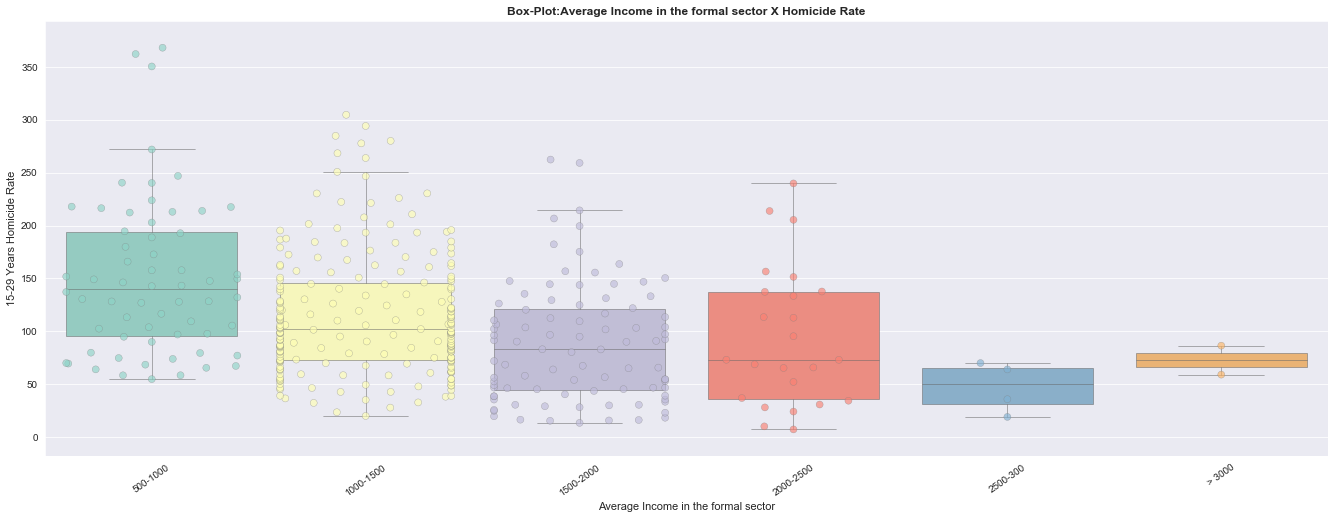

In [114]:
def plot_box(dataset,x,y,xlabel,ylabel,title):
    #plotting a box-splot chart
    sea.set_style('darkgrid', {'axes.grid': True})
    plt.figure()
    box = sea.boxplot(data = dataset, x = x, y =y, palette = "Set3", orient = "v", linewidth = 0.5, saturation= 0.76, fliersize= 0)
    swarm = sea.swarmplot(data = dataset, x = x, y = y, palette = 'Set3', orient = 'v', size = 7,alpha= 0.64, edgecolor= 'grey', linewidth = 0.4)
    plt.xlabel(xlabel,fontsize = 11)
    plt.ylabel(ylabel, fontsize = 11)
    #box.set(xlabel = "Performance (%)", ylabel = "School")
    plt.title(title, fontweight = 'bold')


    #Adjusts
    plt.gcf().set_size_inches(23,8)
    #plt.gcf().set_dpi(100)
    plt.xticks(rotation = 35)
    #plt.subplots_adjust(left = 0.4)b
plot_box(df_income.sort_values(by ="REN_RENSF_D", ascending = True), y = "HOMICIDE_RATE", x = 'FORM_SEC_QUANTILE',xlabel = "Average Income in the formal sector", ylabel =  "15-29 Years Homicide Rate", title = "Box-Plot:Average Income in the formal sector X Homicide Rate")


#### One-way ANOVA and Kruskal test

In [115]:
#Normality Test
#Using Shapiro-Wilk test to evaluate my data population in order to figure out whether or not my sample data proceeds a Gaussian distribution
stat,p = scipy.stats.shapiro(df_income['HOMICIDE_RATE']) 
alpha = 0.05
if  p < alpha:
    print("p-value {} and test statistic {}. The data dont'n follow a Gaussian distribution".format(p, stat))
if p > alpha:
    print("p-value {} and test statistic {}. I can't conclude the data do not follow a Gaussian shape".format(p,stat))

p-value 9.720602794915933e-12 and test statistic 0.9390568733215332. The data dont'n follow a Gaussian distribution


Text(0.5, 1.0, 'Normal Q-Q Plot')

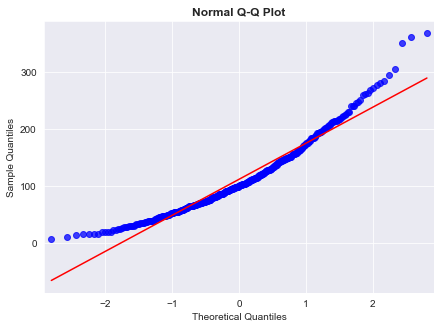

In [116]:
#Q-Q Ploting in order to figure out if the dataset fits a standar normal distribution
import statsmodels.graphics.gofplots as stmod
stmod.qqplot(df_income['HOMICIDE_RATE'], line = 's',  alpha = 0.75, linewidth = 5)
plt.gcf().set_size_inches(7,5)
plt.title('Normal Q-Q Plot', fontweight = 'bold')

**Since our assumptions of the data set having a normal distribution is not true, we are using the Kruskal-Wallis H-test with some loss of test power**

In [118]:
sample_1 = df_income[df_income.FORM_SEC_QUANTILE == "500-1000"]['HOMICIDE_RATE'].to_numpy()
sample_2 = df_income[df_income.FORM_SEC_QUANTILE == "1000-1500"]['HOMICIDE_RATE'].to_numpy()
sample_3 = df_income[df_income.FORM_SEC_QUANTILE == "1500-2000"]['HOMICIDE_RATE'].to_numpy()
sample_4 = df_income[df_income.FORM_SEC_QUANTILE == "2000-2500"]['HOMICIDE_RATE'].to_numpy()
F,p = scipy.stats.kruskal(sample_1,sample_2,sample_3,sample_4)
alpha = 0.05
if p < alpha:
    print("F = {}, p-value = {}. I reject null hypothesis Ho. At least one popullation mean is different from others".format(F,p))
if p > alpha:
     print("F = {}, p-value = {}. I don't have enough evidence to reject  null hypothesisHo. All population means are statistically equal".format(F,p))

F = 36.870930994063656, p-value = 4.899980334541626e-08. I reject null hypothesis Ho. At least one popullation mean is different from others


In [35]:
dict_metric.setdefault('HOMICIDE_RATE', 'Taxa de homicídio: 14-29 anos')

'Taxa de homicídio: 14-29 anos'

In [36]:
df_income = df_income.sort_values(by ="REN_RENSF_D", ascending = True)
df_income

,HOMICIDE_RATE,PIND_POS,PMPOB_POS,PPOB_POS,PBF,REN_PIBPC_D,REN_VAPC_D,REN_PVAAGR,REN_PVAIND,REN_PVAADM,REN_PVASERV,REN_RENSF_D,REN_TRPCBF_D,REN_TRPCBPC_D,TTREVA_EF_TOTAL,TTREVA_EF_PUB,GDP_QUANTILE,FORM_SEC_QUANTILE
CODE,,,,,,,,,,,,,,,,,,
261060,153.805002,29.52,78.63,93.08,76.59,7.70,7.17,32.78,6.16,33.38,27.69,606.09,221.17,163.66,2.5,2.7,0-10,500-1000
130140,142.711519,89.16,98.26,99.62,93.53,7.54,7.31,53.80,2.70,31.88,11.62,714.77,346.77,311.41,8.9,9.0,0-10,500-1000
260090,212.314225,28.41,83.18,94.74,79.42,5.48,5.12,19.35,3.60,48.27,28.78,769.42,177.78,171.20,7.2,8.9,0-10,500-1000
210160,70.036666,37.97,92.06,97.36,87.27,4.61,4.26,7.70,5.74,40.73,45.83,792.10,180.20,264.45,8.8,9.3,0-10,500-1000
330070,146.261555,28.88,67.78,90.35,63.06,22.55,21.09,0.52,27.84,25.04,46.59,816.59,64.85,102.73,3.9,4.3,20-30,500-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350570,19.107250,13.90,59.54,85.98,61.40,118.00,83.80,0.00,12.36,5.13,82.51,2518.23,33.69,113.12,1.8,1.6,> 50,2500-300
330555,64.020487,17.07,58.74,88.11,74.60,16.33,14.92,0.78,27.59,29.33,42.30,2565.43,87.15,55.86,2.7,2.9,10-20,2500-300
420540,35.874761,11.60,36.06,63.57,33.55,25.93,21.05,0.29,10.83,15.30,73.58,2963.30,12.39,56.98,2.0,2.2,20-30,2500-300


In [37]:
df_income.groupby(by = 'FORM_SEC_QUANTILE').agg({variable: [np.mean, np.std]})

REN_PIBPC_D           
                         mean        std
FORM_SEC_QUANTILE                       
1000--1500          13.410184   6.975194
1500-2000           25.546593  11.947313
2000-2500           29.411667  15.994936
2500-300            50.095000  46.312749
500-1000             8.745806   5.061249
> 3000              50.630000   2.672864

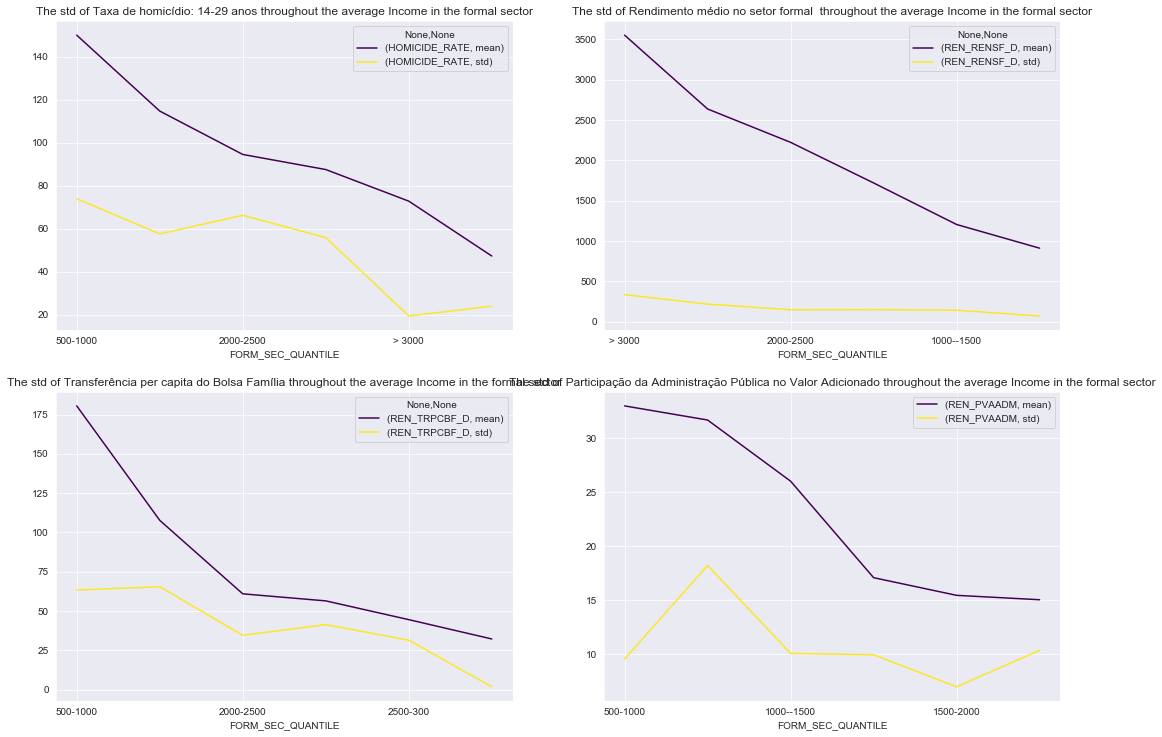

In [38]:
#Plotting the variance
variables = ["HOMICIDE_RATE","REN_RENSF_D","REN_TRPCBF_D","REN_PVAADM" ]
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
axes = [ax1,ax2,ax3,ax4]

for ax,variable in zip(axes,variables):
    df_var = df_income.groupby(by = 'FORM_SEC_QUANTILE').agg({variable: [np.mean, np.std]})
    df_var = df_var.sort_values(by = df_var.columns[0], ascending = False)
    df_var.plot(fig = (10,5), title = "The std of {} throughout the average Income in the formal sector".format(dict_metric[variable]),ax = ax, cmap = 'viridis')


plt.legend(loc= 'best')
plt.gcf().set_size_inches(18,8)
plt.subplots_adjust(bottom = -0.3)

In [39]:
df_var = df_income.groupby(by = 'FORM_SEC_QUANTILE').agg({"HOMICIDE_RATE": np.std })
df_var = df_var.sort_values(by = df_var.columns[0], ascending = False)
df_var = df_var.drop(df_var.index[-1], axis = 0)
df_var.index =  [500,1000,1500,2000,2500]
df_var

,HOMICIDE_RATE
500,73.913038
1000,66.194215
1500,57.530955
2000,55.819049
2500,23.956708


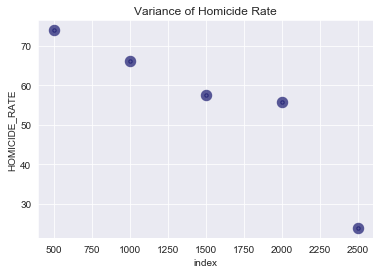

In [40]:
#using interpolation to figure out the best equation that interpolate the 6 points of variance
plot_var = df_var.reset_index().plot(kind = 'scatter', y ="HOMICIDE_RATE", x = "index", linewidth = 7, alpha = 0.7, color ='midnightblue', title = "Variance of Homicide Rate")

#### Apply Newton method do interpolate all points
### $ P(x) = [y_0] + (x -x_0)[y_0,y_1] + (x-x_0)(x-x_1)[y_0,y_1,y_2] + (x-x_0)(x-x_1)...(x-x_{k-1})[y_0,...,y_k]$

#### The standar deviation of some variables throughout  the average income in the formal sector

In [41]:
df_var

,HOMICIDE_RATE
500,73.913038
1000,66.194215
1500,57.530955
2000,55.819049
2500,23.956708


In [77]:
def Newton(X,Y, xi):
    'input: dataset (x,y) and x value'
    'output: display of pyramid of divided difference and the respective y value'
    n = np.shape(Y)[0]
    pyramid =  np.zeros([n,n]) #Table of divided - difference
    df = pd.DataFrame(pyramid)
    df[0] = Y  #including Yi values in the first columns
    for j in range(1,n):
        for i in range(n-j):
            #Creating pyramid of divided difference updating each column
            df.iloc[i,j] = (df.iloc[i+1,j-1] -df.iloc[i,j-1])/(X[i+j] - X[i])
    #display(df)     
    #Newton Polynomial
    coef = 1 
    yi = df.iloc[0,0]
    for i in range(n-1): #iterate in order to have polynomial
        coef *= (xi - X[i]) # (x-X0)(x-X1)....(x-Xi-1) for i + n distinct points, i= 0,1,2... n 
        yi =  yi  + df.iloc[0,i+1] *coef # f(x) = [y0] + (x-x0)[y0,y1] +(x-x0)(x-1)[y0,y1,y2].....
    return (yi,df)

#Plotting
Ystd = df_var.values
Xfi = df_var.index
xplot = np.linspace(Xfi[0], Xfi[-1], num = 100)
yplot = []
for x in xplot:
    yplot.append(Newton(Xfi,Ystd,x)[0])
yplot = np.array(yplot)

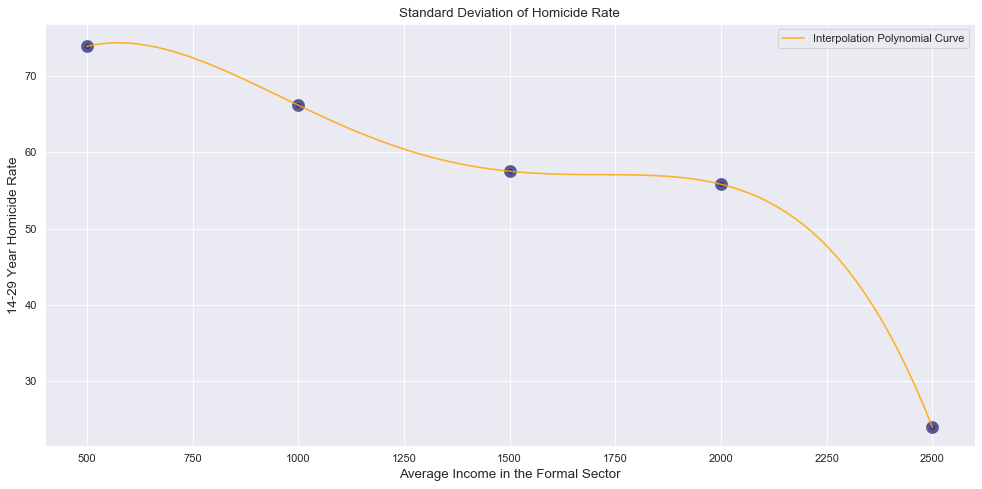

In [87]:
#variance
df_var.reset_index().plot(kind = 'scatter',y ="HOMICIDE_RATE", x = "index", linewidth = 7, alpha = 0.7, color ='midnightblue', title = "Standard Deviation of Homicide Rate")
#interpolate
plt.plot(xplot,yplot, '-b', color = 'orange', alpha = 0.8, label = 'Interpolation Polynomial Curve')

#plt.xlabel('GDP per Capita')
plt.legend(loc = 'best')
plt.xlabel("Average Income in the Formal Sector", fontsize = 12)
plt.ylabel("14-29 Year Homicide Rate", fontsize = 12)
plt.gcf().set_size_inches(15,7)
plt.gcf().set_dpi(80)

### Revisitng the non-linear regression for the the Average Income in the formal sector

In [44]:
#Input variable
variable = "REN_RENSF_D"

df_check = df_check.sort_values(by = variable, ascending = True)
#Computing the correlation between GDP per capita and homicide rate
corr_gdp = df_check['HOMICIDE_RATE'].corr(df_check[variable], method = "pearson")
print('Corr: ', corr_gdp )

Corr:  -0.30278120175906675


In [45]:
# Linear regression (Ordinary least squares)
#Using a first degree equation (f(x) = a + bx) to approximate

X = df_check[variable].to_numpy()
Y = df_check['HOMICIDE_RATE'].to_numpy()


In [46]:
#Applying  least squares algorithm

m = 3 # number of matrix colum/row (mXm) - n+1 equations
A = np.zeros([m,m]) # Produt scalar matrix [<Gi,Gj>] mXm
B = np.zeros([m,1]) # Independent matrix [<Gj,Yi]> mx1

for i in range(m): # n + 1 degree equation
    for j in range(m):
        A[i][j] = np.sum((X**i)*(X**j))     
        
for i in range(m):
    B[i][0] = np.sum(Y*X**i)

#Linear System solution AX = B --> X = BA^-1
matrix_solution = np.linalg.inv(A).dot(B)
a,b,c = matrix_solution

G = 0
for i in range(len(matrix_solution)):
    G += matrix_solution[i]*X**i    

In [47]:
print('SSE: ', np.sum((Y-G)**2))

SSE:  1421752.9943593948


I Want to model my data by a negative  negative exponential function becasuse I believe it's the most suitable equation. So I should apply non-linear regression
- Function I will approximate: $ \Large H(x) = \frac{s}{x^t}$
- Linearization: $z(x) = ln(H(x)) = ln(s) - ln(x)t \Rightarrow \alpha = ln(s) \space,\space \beta = -b \space,\space t(x) = ln(x) $
- Linearized function: $z(x) = \alpha + \beta x$

In [48]:
#Non linear regression

#log of function G(x)
#T = np.log(X)
Z =np.log(Y)
T = np.log(X)

H = {0: np.array([1]*len(T)), 1:T} #My approximation function h(X)= alpha + beta X
m = len(H) # number of matrix colum/row (mXm) - n+1 equations
A = np.zeros([m,m]) # Produt scalar matrix [<Gi,Gj>] mXm
B = np.zeros([m,1]) # Independent matrix [<Gj,Yi]> mx1


for i in range(m): # n + 1 degree equation
    for j in range(m):
        A[i][j] = np.sum(H[i]*H[j])     
        
for i in range(m):
    B[i][0] = np.sum(Z*H[i])

#Linear System solution AX = B --> X = BA^-1
matrix_solution = np.linalg.inv(A).dot(B)
alpha,beta = matrix_solution

#Figure out the constants of the exponential function
s = np.exp(alpha)
t= - beta

#G(X)
#G_non_linear =s * np.exp(-t*X)
G_non_linear = (s[0]/((X-250)**t[0])) -30
G_non_linear = np.nan_to_num(G_non_linear)

In [49]:
G_non_linear = np.nan_to_num(G_non_linear)

#Sum of squared error
print('SSE: ', np.sum((Y-G_non_linear)**2))


SSE:  1681143.146661026


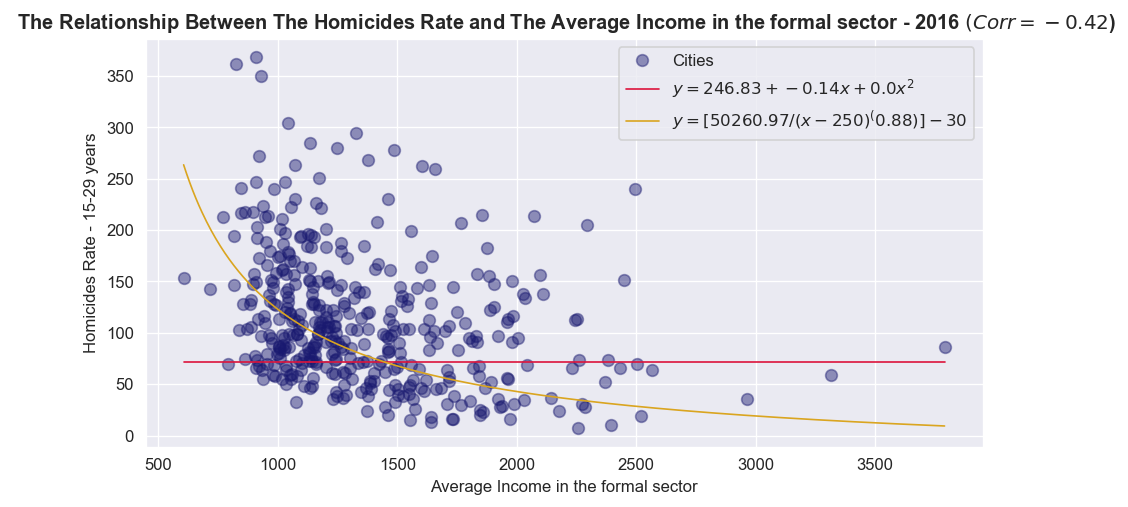

In [75]:
#Plotting---------------------------------------

plt.figure()
sea.set_style('darkgrid', {'axis.grid': True})

#Scatter
plt.plot(X,Y,'o',linewidth = 2.4, markersize = 7, alpha = 0.45, label = 'Cities', c = 'midnightblue')
    
#Labels
plt.xlabel('Average Income in the formal sector')
plt.ylabel('Homicides Rate - 15-29 years')
plt.title(' The Relationship Between The Homicides Rate and The Average Income in the formal sector - {} $(Corr = {}$)'.format(year,round(corr_gdp,2)), fontweight = 'bold')

#Fitting data
xplot = np.linspace(X[0],X[-1],500)
hplot =np.array([],float)
gplot =np.array([],float)# g(x) = a + bx + cx^2
for xi in xplot:
    hi = (s/((xi-250)**t)) -30
    hplot = np.append(hplot,hi)
    gi = a + b*x + c*x**2
    gplot = np.append(gplot,gi)
    


plt.plot(xplot,gplot,'-', linewidth = 1, c= 'crimson', label = '$y = {} + {}x + {}x^2$'.format(round(a[0],2),round(b[0],2),round(c[0],2)))
#plt.plot(xplot, fplot,'-', linewidth = 1, c= 'midnightblue', label = '$y = {} + {}x$'.format(round(a0,2),round(a1,2)))
plt.plot(xplot, hplot,'-', linewidth = 1, c= 'goldenrod', label = '$y = [{}/(x-250)^ ({})]-30$'.format(round(s[0],2),round(t[0],2)))

#Legend
plt.legend(loc = 'best', shadow = False, frameon = True, framealpha = 0.8)
#Settings
plt.gcf().set_dpi(120)
plt.gcf().set_size_inches(9,4.5)

$HR = \Large \frac{50261}{(I_{FS} -250)^{0.88}} - 30 \pm P_4 (I_{FS}) $
 - $HR$ is the homicide rate between 15-29 years people
 - $I_{FS}$ is the average income in the formal sector
 - $P_4 (I_{FS})$ is a 4 degree polynomial regarding the variance of standard deviation of homicide rate
 -  The non-linear model of homicide rate as a function of average income in the formal sector is corrected by a 4th-degree polynomial representing the variation of the standard deviation along with the average income.

In [127]:
def homicide_form_income(income,polynomial,s= s,t = t, Xfi = Xfi, Ystd = Ystd ):
    HR = (s[0]/((income-250)**t[0])) -30
    P = polynomial(Xgdp,Yvar,income)[0]
    HRmax = HR+P
    HRmin = HR -P
    if HRmin < 0:
        HRmin = 0
    return np.array([HRmin,HR,HRmax])

In [124]:
delta = homicide_form_income(income =900 ,polynomial = Newton) - homicide_form_income(income =800,polynomial = Newton)
delta

array([-24.80764996, -27.29865234, -29.78965472])

**Note:**
- According to our model, if we raise the average income in the formal  sector by 100 BRL in a random city, we can reduce the homicide rate down by 25 to 30 murders per 100 habitants  

### Validation

In [132]:
df_check["HR min  predicted"] = df_check["REN_RENSF_D"].apply(lambda x: homicide_form_income(x, polynomial = Newton)[0])
df_check["HR predicted"] = df_check["REN_RENSF_D"].apply(lambda x: homicide_form_income(x, polynomial = Newton)[1])
df_check["HR max  predicted"] = df_check["REN_RENSF_D"].apply(lambda x: homicide_form_income(x, polynomial = Newton)[2])
df_check[['HOMICIDE_RATE', "REN_RENSF_D","HR min  predicted","HR predicted","HR max  predicted" ]].head(50)

,HOMICIDE_RATE,REN_RENSF_D,HR min predicted,HR predicted,HR max predicted
222,153.805002,606.09,189.279276,263.588808,337.898341
367,142.711519,714.77,129.457014,202.531202,275.605389
392,212.314225,769.42,108.944831,180.969242,252.993653
288,70.036666,792.10,101.693958,173.222654,244.751350
71,146.261555,816.59,94.550751,165.512584,236.474418
249,194.571456,817.79,94.217527,165.150838,236.084149
399,362.209478,824.93,92.265458,163.027741,233.790024
281,102.564103,837.67,88.907940,159.359774,229.811609
363,216.483686,844.87,87.078415,157.352043,227.625670
270,240.545236,846.32,86.715695,156.953209,227.190723
